# Extract building height and added into RF regression model

In [8]:
import geopandas as gpd
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
import rasterio
import rasterio.mask
from tqdm import tqdm
from shapely.geometry import Polygon

## Read in files
* building height rasters - from AGO aerial survey data
* building height layer from 3D-GloBFP data
* cleaned building footprint data

In [2]:
building_height_rst_Launceston=r'F:\Elevation\Launceston\AGO\DEM_DSM_DTM\Source Elevation Data\AUS_Launceston_2021_DSM\dsm\building_height_launceston_resample_20cm.tif'
building_height_rst_Wagga=r'F:\Elevation\WaggaWagga\AGO\Matrix\DEM_DSM_DTM\Source Elevation Data\AUS_WaggaWagga_2021_DSM\dsm\building_height_Wagga_resample_20cm.tif'
building_height_lyr_Launceston=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\building_height\Launceston_building_height.shp'
building_height_lyr_Wagga=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\building_height\Wagga_building_height.shp'
footprint_lyr_Launceston=r'Lanceston_footprint_intermediate.geojson'
footprint_lyr_Wagga=r'Wagga_footprint_intermediate.geojson'

In [3]:
gdf_footprint_launceston=gpd.read_file(footprint_lyr_Launceston)
gdf_footprint_launceston.head()

,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,lid_x,...,survey_ind_y,survey_nr__y,survey_par_y,survey_res_y,survey_roo_y,survey_wal_y,vulnerabil_y,range_dem_y,floor_height_m,geometry
0,GATAS702223569,"10 EDDINGTON CRESCENT, INVERMAY, TAS 7248",3.37,3.670,LC_Final.shp,Step counting,0,4.20,50.0,GNAF_GATAS702223569,...,None,None,None,None,None,None,None,0.300,0.614426,"POLYGON ((147.13175 -41.41326, 147.13185 -41.4..."
1,GATAS702235784,"11 DARWIN STREET, INVERMAY, TAS 7248",1.05,1.240,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235784,...,None,None,None,None,None,None,None,0.190,0.843872,"POLYGON ((147.12949 -41.4252, 147.12952 -41.42..."
2,GATAS702270692,"15 HUNTER STREET, INVERMAY, TAS 7248",1.11,1.450,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702270692,...,None,None,None,None,None,None,None,0.340,0.660833,"POLYGON ((147.13349 -41.42877, 147.13354 -41.4..."
3,GATAS702302454,"26 MOORE STREET, INVERMAY, TAS 7248",1.09,1.350,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702302454,...,None,None,None,None,None,None,None,0.260,0.697710,"POLYGON ((147.12809 -41.42433, 147.12814 -41.4..."
4,GATAS702235785,"13 DARWIN STREET, INVERMAY, TAS 7248",1.11,1.260,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235785,...,None,None,None,None,None,None,None,0.150,0.751250,"POLYGON ((147.12934 -41.42524, 147.12938 -41.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,GATAS720841665,"UNIT 1 30 BOLAND STREET, LAUNCESTON, TAS 7250",1.79,2.204,LC_Final.shp,Surveyed,0,2.40,90.0,GNAF_GATAS702198732,...,None,None,None,None,None,None,None,0.414,0.464113,"POLYGON ((147.14399 -41.42913, 147.14408 -41.4..."
673,GATAS719385174,"UNIT A 21 GLEADOW STREET, INVERMAY, TAS 7248",1.25,1.650,LC_Final.shp,Surveyed,0,2.04,90.0,GNAF_GATAS702473546,...,None,None,None,None,None,None,None,0.400,0.693513,"POLYGON ((147.13539 -41.42699, 147.13543 -41.4..."
674,GATAS702473546,"21 GLEADOW STREET, INVERMAY, TAS 7248",1.25,1.650,LC_Final.shp,Surveyed,0,2.04,90.0,GNAF_GATAS702473546,...,None,None,None,None,None,None,None,0.400,0.693513,"POLYGON ((147.13539 -41.42699, 147.13543 -41.4..."
675,GATAS718791627,"UNIT B 21 GLEADOW STREET, INVERMAY, TAS 7248",1.25,1.650,LC_Final.shp,Surveyed,0,2.04,90.0,GNAF_GATAS702473546,...,None,None,None,None,None,None,None,0.400,0.693513,"POLYGON ((147.13539 -41.42699, 147.13543 -41.4..."


In [4]:
gdf_footprint_Wagga=gpd.read_file(footprint_lyr_Wagga)
gdf_footprint_Wagga.head()

,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,x_x,...,lid_y,index_y,nexis_wall_type_y,generic_ext_wall_y,local_year_built_y,nexis_year_built_y,nexis_construction_type_y,flood_vulnerability_function_id_y,range_dem_y,geometry
0,GANSW717069108,"LOT 1 721 OURA ROAD, EUNANOREENYA, NSW 2650",183.057,183.358,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.604,90.0,541677.06,...,GANSW717069108,51634.0,Veneer Masonry,brick_veneer,2010,2007 - 2011,SH,FCM7,0.301,"POLYGON ((147.45741 -35.08803, 147.45706 -35.0..."
1,GANSW705588391,"LOT 1 5 MILL STREET, NORTH WAGGA WAGGA, NSW 2650",179.217,179.570,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,535023.82,...,GANSW705588391,51290.0,Veneer Masonry,brick_veneer,2000,1997 - 2001,SH,FCM7,0.353,"POLYGON ((147.38423 -35.09555, 147.38423 -35.0..."
2,GANSW712762892,"LOT 1 87 HILLARY STREET, NORTH WAGGA WAGGA, NS...",181.501,183.651,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,536472.03,...,GANSW712762892,51467.0,Veneer Masonry,brick_veneer,1993,1992 - 1996,SH,FCM7,2.150,"POLYGON ((147.4001 -35.09252, 147.40018 -35.09..."
3,GANSW712725182,"LOT 2 28 MCNICKLE ROAD, MOORONG, NSW 2650",179.198,179.766,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,529357.53,...,GANSW712725182,48190.0,Veneer Masonry,brick_veneer,1979,1977 - 1981,SH,FCM7,0.568,"POLYGON ((147.32212 -35.11953, 147.32245 -35.1..."
4,GANSW712752850,"3849 STURT HIGHWAY, GUMLY GUMLY, NSW 2652",182.935,183.101,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.342,90.0,539411.94,...,GANSW712752850,46019.0,Veneer Masonry,brick_veneer,1994,1992 - 1996,SH,FCM7,0.166,"POLYGON ((147.43251 -35.12818, 147.43247 -35.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,GANSW705582357,"LOT 24 15 HENRY STREET, NORTH WAGGA WAGGA, NSW...",179.531,180.016,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.850,90.0,534225.76,...,GANSW705582357,51228.0,Veneer Masonry,brick_veneer,1993,1992 - 1996,SH,FCM8,0.485,"POLYGON ((147.37563 -35.09621, 147.37549 -35.0..."
223,GANSW705582325,"LOT 65 14 HAMPDEN AVENUE, NORTH WAGGA WAGGA, N...",179.593,179.802,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.640,90.0,534259.66,...,GANSW705582325,51134.0,Veneer Masonry,brick_veneer,2005,2002 - 2006,SH,FCM7,0.209,"POLYGON ((147.37581 -35.09802, 147.37576 -35.0..."
224,GANSW712752851,"3854 STURT HIGHWAY, GUMLY GUMLY, NSW 2652",182.410,182.601,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.400,90.0,539425.26,...,GANSW712752851,46455.0,Veneer Masonry,brick_veneer,1994,1992 - 1996,SH,FCM7,0.191,"POLYGON ((147.4327 -35.12702, 147.43265 -35.12..."
225,GANSW705582328,"LOT 62 18 HAMPDEN AVENUE, NORTH WAGGA WAGGA, N...",179.408,179.722,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.889,90.0,534294.25,...,GANSW705582328,51142.0,Veneer Masonry,brick_veneer,1993,1992 - 1996,SH,FCM7,0.314,"POLYGON ((147.37614 -35.09785, 147.37609 -35.0..."


In [5]:
gdf_bd_height_Launceston=gpd.read_file(building_height_lyr_Launceston)
gdf_bd_height_Launceston

,FID_1,Height,geometry
0,375018,5.442862,"POLYGON ((147.12087 -41.43483, 147.12097 -41.4..."
1,375306,5.499766,"POLYGON ((147.12568 -41.43681, 147.1258 -41.43..."
2,375594,4.155178,"POLYGON ((147.13145 -41.40621, 147.13149 -41.4..."
3,375786,10.063231,"POLYGON ((147.13205 -41.42412, 147.13196 -41.4..."
4,375818,4.795486,"POLYGON ((147.13219 -41.4191, 147.13209 -41.41..."
...,...,...,...
7973,6787550,4.783794,"POLYGON ((147.11963 -41.442, 147.11975 -41.441..."
7974,8231150,5.650927,"POLYGON ((147.12147 -41.4459, 147.12151 -41.44..."
7975,9665862,5.909421,"POLYGON ((147.15654 -41.40553, 147.1564 -41.40..."
7976,9675133,4.100958,"POLYGON ((147.11381 -41.41725, 147.11386 -41.4..."


In [6]:
gdf_bd_height_Wagga=gpd.read_file(building_height_lyr_Wagga)
gdf_bd_height_Wagga

,FID_1,Height,geometry
0,384906,4.961997,"POLYGON ((147.32111 -35.12892, 147.32098 -35.1..."
1,385418,5.115966,"POLYGON ((147.33101 -35.12425, 147.33101 -35.1..."
2,385640,4.811138,"POLYGON ((147.3212 -35.13103, 147.32113 -35.13..."
3,385674,7.822640,"POLYGON ((147.33646 -35.14497, 147.33671 -35.1..."
4,385738,5.292119,"POLYGON ((147.3381 -35.13324, 147.3383 -35.133..."
...,...,...,...
18105,11073069,4.696795,"POLYGON ((147.34515 -35.08131, 147.34523 -35.0..."
18106,11074763,6.851367,"POLYGON ((147.40653 -35.08044, 147.40649 -35.0..."
18107,11076355,4.441855,"POLYGON ((147.39626 -35.09331, 147.39619 -35.0..."
18108,11078704,5.156131,"POLYGON ((147.32956 -35.11159, 147.32959 -35.1..."


## Extract Building height
### using AGO data
* Launceston

In [ ]:
# Open the raster to get its CRS
with rasterio.open(building_height_rst_Launceston) as src:
    raster_crs = src.crs
raster_crs
gdf_footprint_launceston=gdf_footprint_launceston.to_crs(raster_crs)
# define zonal aggregation operation mapping
mapping_stats = {
    "max":np.max,
    "mean": np.mean,
    "median": np.median,
    "std": np.std,
    "1st_quantile": lambda data: np.quantile(data, 0.25)
}

# Function to calculate statistics for a single geometry
def calculate_stats(raster, geometry, operation):
    # Mask the raster with the geometry
    out_image, out_transform = rasterio.mask.mask(raster, [geometry], crop=True, nodata=raster.nodata)
    data = out_image[0]
    # Exclude nodata values
    data = data[data != raster.nodata]
    if data.size == 0:
        return None  # No valid data within the zone
    stats=mapping_stats[operation](data)
    return stats

max_height_bdgs=[]
mean_height_bdgs=[]
median_height_bdgs=[]
quantile_height_bdgs=[]
# Open the VRT file
with rasterio.open(building_height_rst_Launceston) as rst:
    # Calculate zonal statistics for each zone
    for idx, poly in tqdm(gdf_footprint_launceston.iterrows(),total=len(gdf_footprint_launceston)):
        # get building height
        max_height_bdg=calculate_stats(rst,poly.geometry, 'max')
        mean_height_bdg=calculate_stats(rst, poly.geometry, 'mean')
        median_height_bdg=calculate_stats(rst, poly.geometry, 'median')
        quantile_height_bdg=calculate_stats(rst, poly.geometry, '1st_quantile')
        max_height_bdgs.append(max_height_bdg)
        mean_height_bdgs.append(mean_height_bdg)
        median_height_bdgs.append(median_height_bdg)
        quantile_height_bdgs.append(quantile_height_bdg)

# assign new columns for storing statistics
gdf_footprint_launceston['max_height_building'] = max_height_bdgs
gdf_footprint_launceston['mean_height_building'] = mean_height_bdgs
gdf_footprint_launceston['median_height_building'] = median_height_bdgs
gdf_footprint_launceston['quantiles_height_building'] = quantile_height_bdgs
gdf_footprint_launceston.head()

100%|██████████| 677/677 [01:35<00:00,  7.12it/s]


,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,lid_x,...,survey_roo_y,survey_wal_y,vulnerabil_y,range_dem_y,floor_height_m,geometry,max_height_building,mean_height_building,median_height_building,quantiles_height_building
0,GATAS702223569,"10 EDDINGTON CRESCENT, INVERMAY, TAS 7248",3.37,3.67,LC_Final.shp,Step counting,0,4.20,50.0,GNAF_GATAS702223569,...,None,None,None,0.30,0.614426,"POLYGON ((511010.623 5415357.555, 511019.197 5...",6.108642,4.037501,4.212604,3.614461
1,GATAS702235784,"11 DARWIN STREET, INVERMAY, TAS 7248",1.05,1.24,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235784,...,None,None,None,0.19,0.843872,"POLYGON ((510819.838 5414031.856, 510822.48 54...",5.899278,3.274364,3.858672,1.163775
2,GATAS702270692,"15 HUNTER STREET, INVERMAY, TAS 7248",1.11,1.45,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702270692,...,None,None,None,0.34,0.660833,"POLYGON ((511153.989 5413635.303, 511157.629 5...",6.039920,2.781369,3.153023,0.430827
3,GATAS702302454,"26 MOORE STREET, INVERMAY, TAS 7248",1.09,1.35,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702302454,...,None,None,None,0.26,0.697710,"POLYGON ((510703.283 5414128.893, 510707.324 5...",6.569089,3.407822,4.144881,1.856090
4,GATAS702235785,"13 DARWIN STREET, INVERMAY, TAS 7248",1.11,1.26,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235785,...,None,None,None,0.15,0.751250,"POLYGON ((510807.657 5414027.434, 510811.015 5...",5.658770,3.289159,3.423900,1.638533


* Wagga

In [17]:
# Open the raster to get its CRS
with rasterio.open(building_height_rst_Wagga) as src:
    raster_crs = src.crs
raster_crs
gdf_footprint_Wagga=gdf_footprint_Wagga.to_crs(raster_crs)

max_height_bdgs=[]
mean_height_bdgs=[]
median_height_bdgs=[]
quantile_height_bdgs=[]
# Open the VRT file
with rasterio.open(building_height_rst_Wagga) as rst:
    # Calculate zonal statistics for each zone
    for idx, poly in tqdm(gdf_footprint_Wagga.iterrows(),total=len(gdf_footprint_Wagga)):
        try:
            # get building height
            max_height_bdg=calculate_stats(rst,poly.geometry, 'max')
            mean_height_bdg=calculate_stats(rst, poly.geometry, 'mean')
            median_height_bdg=calculate_stats(rst, poly.geometry, 'median')
            quantile_height_bdg=calculate_stats(rst, poly.geometry, '1st_quantile')
        except ValueError:
            max_height_bdg=np.nan
            mean_height_bdg=np.nan
            median_height_bdg=np.nan
            quantile_height_bdg=np.nan
        max_height_bdgs.append(max_height_bdg)
        mean_height_bdgs.append(mean_height_bdg)
        median_height_bdgs.append(median_height_bdg)
        quantile_height_bdgs.append(quantile_height_bdg)

# assign new columns for storing statistics
gdf_footprint_Wagga['max_height_building'] = max_height_bdgs
gdf_footprint_Wagga['mean_height_building'] = mean_height_bdgs
gdf_footprint_Wagga['median_height_building'] = median_height_bdgs
gdf_footprint_Wagga['quantiles_height_building'] = quantile_height_bdgs
gdf_footprint_Wagga.head()

100%|██████████| 227/227 [00:13<00:00, 16.95it/s]


,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,x_x,...,local_year_built_y,nexis_year_built_y,nexis_construction_type_y,flood_vulnerability_function_id_y,range_dem_y,geometry,max_height_building,mean_height_building,median_height_building,quantiles_height_building
0,GANSW717069108,"LOT 1 721 OURA ROAD, EUNANOREENYA, NSW 2650",183.057,183.358,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.604,90.0,541677.06,...,2010,2007 - 2011,SH,FCM7,0.301,"POLYGON ((541695.134 6117099.521, 541663.031 6...",NaN,NaN,NaN,NaN
1,GANSW705588391,"LOT 1 5 MILL STREET, NORTH WAGGA WAGGA, NSW 2650",179.217,179.570,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,535023.82,...,2000,1997 - 2001,SH,FCM7,0.353,"POLYGON ((535020.599 6116293.74, 535020.945 61...",5.254456,3.258692,3.136993,2.947983
2,GANSW712762892,"LOT 1 87 HILLARY STREET, NORTH WAGGA WAGGA, NS...",181.501,183.651,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,536472.03,...,1993,1992 - 1996,SH,FCM7,2.150,"POLYGON ((536468.784 6116623.4, 536476.037 611...",189.777634,186.023605,186.081207,185.622738
3,GANSW712725182,"LOT 2 28 MCNICKLE ROAD, MOORONG, NSW 2650",179.198,179.766,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,529357.53,...,1979,1977 - 1981,SH,FCM7,0.568,"POLYGON ((529351.265 6113653.909, 529381.642 6...",10.973831,3.570630,3.916817,3.433445
4,GANSW712752850,"3849 STURT HIGHWAY, GUMLY GUMLY, NSW 2652",182.935,183.101,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.342,90.0,539411.94,...,1994,1992 - 1996,SH,FCM7,0.166,"POLYGON ((539405.989 6112656.25, 539401.622 61...",NaN,NaN,NaN,NaN


### using 3D-GloBFP data
* Launceston

In [18]:
# Ensure GeoDataFrames have the same CRS
if gdf_footprint_launceston.crs != gdf_bd_height_Launceston.crs:
    gdf_bd_height_Launceston = gdf_bd_height_Launceston.to_crs(gdf_footprint_launceston.crs)

# Calculate centroids of polygons in A and B
gdf_footprint_launceston['centroid'] = gdf_footprint_launceston.geometry.centroid
gdf_bd_height_Launceston['centroid'] = gdf_bd_height_Launceston.geometry.centroid

def get_building_height(row, gdf_building_height, attribute_col):
    # Calculate distances to current geometry 
    distances = gdf_building_height['centroid'].distance(row['centroid'])
    # Find the index of the nearest polygon
    nearest_idx = distances.idxmin()
    # Return the attribute value of the nearest polygon
    return gdf_building_height.loc[nearest_idx, attribute_col]

# Apply the function to GeoDataFrame A
gdf_footprint_launceston['height_globfp'] = gdf_footprint_launceston.apply(get_building_height, axis=1, gdf_building_height=gdf_bd_height_Launceston, attribute_col='Height')
gdf_footprint_launceston.head()

,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,lid_x,...,vulnerabil_y,range_dem_y,floor_height_m,geometry,max_height_building,mean_height_building,median_height_building,quantiles_height_building,centroid,height_globfp
0,GATAS702223569,"10 EDDINGTON CRESCENT, INVERMAY, TAS 7248",3.37,3.670,LC_Final.shp,Step counting,0,4.20,50.0,GNAF_GATAS702223569,...,None,0.300,0.614426,"POLYGON ((511010.623 5415357.555, 511019.197 5...",6.108642,4.037501,4.212604,3.614461,POINT (511011.1 5415366.269),4.151800
1,GATAS702235784,"11 DARWIN STREET, INVERMAY, TAS 7248",1.05,1.240,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235784,...,None,0.190,0.843872,"POLYGON ((510819.838 5414031.856, 510822.48 54...",5.899278,3.274364,3.858672,1.163775,POINT (510826.501 5414028.288),9.820625
2,GATAS702270692,"15 HUNTER STREET, INVERMAY, TAS 7248",1.11,1.450,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702270692,...,None,0.340,0.660833,"POLYGON ((511153.989 5413635.303, 511157.629 5...",6.039920,2.781369,3.153023,0.430827,POINT (511160.087 5413630.119),14.626005
3,GATAS702302454,"26 MOORE STREET, INVERMAY, TAS 7248",1.09,1.350,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702302454,...,None,0.260,0.697710,"POLYGON ((510703.283 5414128.893, 510707.324 5...",6.569089,3.407822,4.144881,1.856090,POINT (510709.835 5414123.454),11.803862
4,GATAS702235785,"13 DARWIN STREET, INVERMAY, TAS 7248",1.11,1.260,LC_Final.shp,Step counting,0,1.96,50.0,GNAF_GATAS702235785,...,None,0.150,0.751250,"POLYGON ((510807.657 5414027.434, 510811.015 5...",5.658770,3.289159,3.423900,1.638533,POINT (510814.612 5414022.95),10.257978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,GATAS720841665,"UNIT 1 30 BOLAND STREET, LAUNCESTON, TAS 7250",1.79,2.204,LC_Final.shp,Surveyed,0,2.40,90.0,GNAF_GATAS702198732,...,None,0.414,0.464113,"POLYGON ((512030.915 5413593.765, 512038.807 5...",7.953198,4.489040,4.542509,3.996069,POINT (512037.51 5413592.531),11.882986
673,GATAS719385174,"UNIT A 21 GLEADOW STREET, INVERMAY, TAS 7248",1.25,1.650,LC_Final.shp,Surveyed,0,2.04,90.0,GNAF_GATAS702473546,...,None,0.400,0.693513,"POLYGON ((511312.858 5413832.358, 511316.282 5...",6.845333,3.077623,3.718294,0.974891,POINT (511319.661 5413827.651),11.834415
674,GATAS702473546,"21 GLEADOW STREET, INVERMAY, TAS 7248",1.25,1.650,LC_Final.shp,Surveyed,0,2.04,90.0,GNAF_GATAS702473546,...,None,0.400,0.693513,"POLYGON ((511312.858 5413832.358, 511316.282 5...",6.845333,3.077623,3.718294,0.974891,POINT (511319.661 5413827.651),11.834415
675,GATAS718791627,"UNIT B 21 GLEADOW STREET, INVERMAY, TAS 7248",1.25,1.650,LC_Final.shp,Surveyed,0,2.04,90.0,GNAF_GATAS702473546,...,None,0.400,0.693513,"POLYGON ((511312.858 5413832.358, 511316.282 5...",6.845333,3.077623,3.718294,0.974891,POINT (511319.661 5413827.651),11.834415


* Wagga

In [19]:
# Ensure GeoDataFrames have the same CRS
if gdf_footprint_Wagga.crs != gdf_bd_height_Wagga.crs:
    gdf_bd_height_Wagga = gdf_bd_height_Wagga.to_crs(gdf_footprint_Wagga.crs)

# Calculate centroids of polygons in A and B
gdf_footprint_Wagga['centroid'] = gdf_footprint_Wagga.geometry.centroid
gdf_bd_height_Wagga['centroid'] = gdf_bd_height_Wagga.geometry.centroid

# Apply the function to GeoDataFrame A
gdf_footprint_Wagga['height_globfp'] = gdf_footprint_Wagga.apply(get_building_height, axis=1, gdf_building_height=gdf_bd_height_Wagga, attribute_col='Height')
gdf_footprint_Wagga.head()

,gnaf_id,gnaf_address_x,min_building_height_ahd_x,max_building_height_ahd_x,dataset_x,method_x,storey_x,floor_height_m_x,accuracy_x,x_x,...,nexis_construction_type_y,flood_vulnerability_function_id_y,range_dem_y,geometry,max_height_building,mean_height_building,median_height_building,quantiles_height_building,centroid,height_globfp
0,GANSW717069108,"LOT 1 721 OURA ROAD, EUNANOREENYA, NSW 2650",183.057,183.358,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.604,90.0,541677.06,...,SH,FCM7,0.301,"POLYGON ((541695.134 6117099.521, 541663.031 6...",NaN,NaN,NaN,NaN,POINT (541678.675 6117090.026),4.912685
1,GANSW705588391,"LOT 1 5 MILL STREET, NORTH WAGGA WAGGA, NSW 2650",179.217,179.570,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,535023.82,...,SH,FCM7,0.353,"POLYGON ((535020.599 6116293.74, 535020.945 61...",5.254456,3.258692,3.136993,2.947983,POINT (535026.583 6116285.957),13.973406
2,GANSW712762892,"LOT 1 87 HILLARY STREET, NORTH WAGGA WAGGA, NS...",181.501,183.651,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,536472.03,...,SH,FCM7,2.150,"POLYGON ((536468.784 6116623.4, 536476.037 611...",189.777634,186.023605,186.081207,185.622738,POINT (536479.108 6116631.129),4.956539
3,GANSW712725182,"LOT 2 28 MCNICKLE ROAD, MOORONG, NSW 2650",179.198,179.766,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.200,90.0,529357.53,...,SH,FCM7,0.568,"POLYGON ((529351.265 6113653.909, 529381.642 6...",10.973831,3.570630,3.916817,3.433445,POINT (529367.196 6113659.652),4.619630
4,GANSW712752850,"3849 STURT HIGHWAY, GUMLY GUMLY, NSW 2652",182.935,183.101,Wagga_Building_Estimated_Levels_floor_heights....,Surveyed,0,0.342,90.0,539411.94,...,SH,FCM7,0.166,"POLYGON ((539405.989 6112656.25, 539401.622 61...",NaN,NaN,NaN,NaN,POINT (539410.848 6112647.329),8.526741


## Compare building heights from the two datasource

Text(0.5, 0, 'Building height (m)')

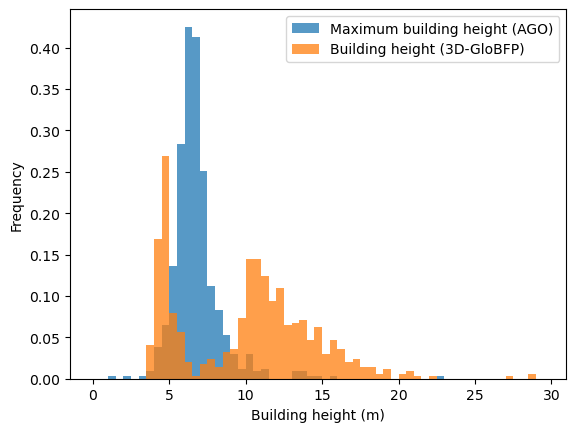

In [26]:
gdf_footprint_launceston.max_height_building.plot.hist(bins=np.arange(0,30,0.5), alpha=0.75, label='Maximum building height (AGO)', density=True)
gdf_footprint_launceston.height_globfp.plot.hist(bins=np.arange(0,30,0.5), alpha=0.75, label='Building height (3D-GloBFP)', density=True)
plt.legend()
plt.xlabel('Building height (m)')

Text(0.5, 0, 'Building height (m)')

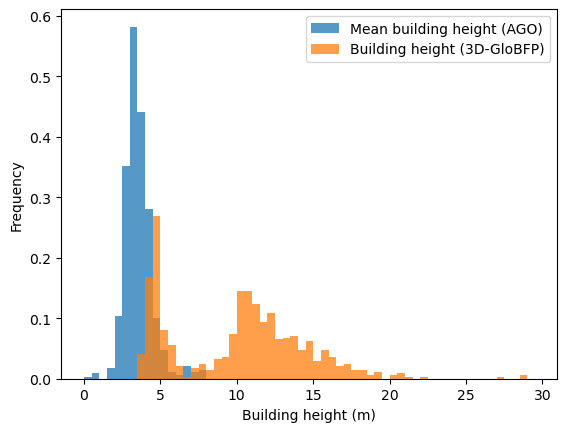

In [27]:
gdf_footprint_launceston.mean_height_building.plot.hist(bins=np.arange(0,30,0.5), alpha=0.75, label='Mean building height (AGO)', density=True)
gdf_footprint_launceston.height_globfp.plot.hist(bins=np.arange(0,30,0.5), alpha=0.75, label='Building height (3D-GloBFP)', density=True)
plt.legend()
plt.xlabel('Building height (m)')

Text(0.5, 0, 'Building height (m)')

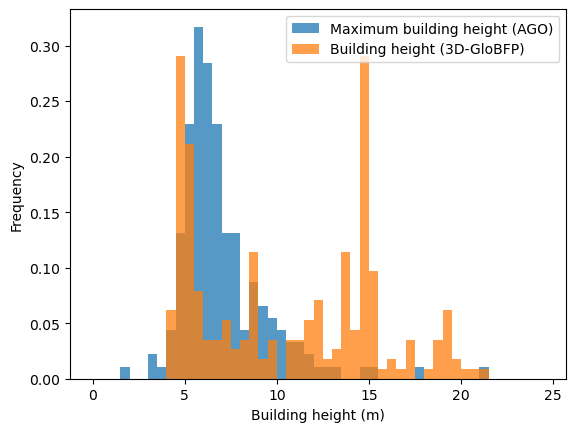

In [28]:
gdf_footprint_Wagga.max_height_building.plot.hist(bins=np.arange(0,25,0.5), alpha=0.75, label='Maximum building height (AGO)', density=True)
gdf_footprint_Wagga.height_globfp.plot.hist(bins=np.arange(0,25,0.5), alpha=0.75, label='Building height (3D-GloBFP)', density=True)
plt.legend()
plt.xlabel('Building height (m)')

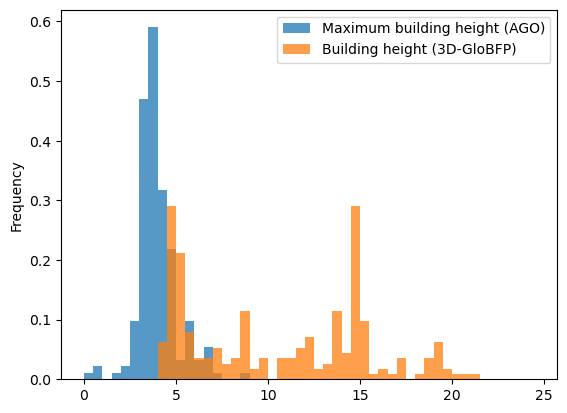

In [25]:
gdf_footprint_Wagga.mean_height_building.plot.hist(bins=np.arange(0,25,0.5), alpha=0.75, label='Maximum building height (AGO)', density=True)
gdf_footprint_Wagga.height_globfp.plot.hist(bins=np.arange(0,25,0.5), alpha=0.75, label='Building height (3D-GloBFP)', density=True)
plt.legend()
plt.xlabel('Building height (m)')

## Build and tune a regression model

* Use selected catagorical and numerical featrures
* Remove highly correlated features


In [72]:
# Features and target
cat_features = ['NEXIS_YEAR_BUILT','NEXIS_CONSTRUCTION_TYPE', 'NEXIS_WALL_TYPE', 'GENERIC_EXT_WALL', 'flood_vulnerability_function_id']#, 'Survey_G_1']
cat_features = [col.lower()+'_y' for col in cat_features]
num_features = ['range_dem','min_building_height_ahd']#, 'LOCAL_YEAR']#, 'max_building_height_ahd'] #,'range_dem_2'] #,'range_dem_2']#, 'LOCAL_YEAR']#, 'range_dem_2']
num_features = [col.lower()+'_y' for col in num_features]
num_features.extend(['max_height_building','mean_height_building','quantiles_height_building']) # add building height as variable
# num_features.append('height_globfp') # add building height as variable
target = 'floor_height_m'

X_raw = gdf_footprint_launceston[cat_features + num_features]
y = gdf_footprint_launceston[target]

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_raw[cat_features])

# Normalize numeric features
scaler = StandardScaler()
scaler.fit(X_raw[num_features])

# Apply the tranformation
X_encoded_categorical = encoder.transform(X_raw[cat_features])
X_normalized_numeric = scaler.transform(X_raw[num_features])

# Concatenate the encoded categorical features with the normalized numeric features
X = np.hstack((X_encoded_categorical, X_normalized_numeric))

ffh_limit = 2

In [73]:
# Remove outliers
X_lt_2m = X[(gdf_footprint_launceston[target]>=0).values & (gdf_footprint_launceston[target]<ffh_limit).values]
y_lt_2m = y[(gdf_footprint_launceston[target]>=0).values & (gdf_footprint_launceston[target]<ffh_limit).values]

In [74]:
# Helper function to remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return X.drop(columns=to_drop, axis=1)

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_keep = [column for column in X_df.columns if not any(upper_triangle[column] > self.threshold)]
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X).loc[:, self.to_keep] if self.to_keep else X

In [75]:
# Bin the target variable into 10 bins
y_binned = pd.cut(y_lt_2m, bins=10, labels=False)

# Count the frequency of each bin
bin_counts = pd.value_counts(y_binned)

# Calculate weights based on frequency of each bin
# Inverse frequency as the weight (you can tweak this)
weights = np.array([1 / bin_counts[label]**2 for label in y_binned])

#weights = np.where((y_binned>1) & (y_binned<5), 1, 10000)


C:\Users\lliu\AppData\Local\Temp\ipykernel_1116\2481863291.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(y_binned)


In [76]:
# Use all data (less than 2m FFH) to tune and find best model

# Pipeline including CorrelationFilter
pipeline = Pipeline([
    # ('correlation_filter', CorrelationFilter(threshold=0.8)),
    #('regressor', XGBRegressor()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [5, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    #'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

# XGB
#param_grid = {
#    'regressor__n_estimators': [50, 100, 200],
#    'regressor__learning_rate': [0.01, 0.1, 0.2],
#    'regressor__max_depth': [3, 5, 7],
#    'regressor__subsample': [0.8, 0.9, 1.0],
#}


# Bin the target variable into 10 bins
y_binned = pd.cut(y_lt_2m, bins=5, labels=False)

# Define a stratified k-fold splitter based on the binned target
stratified_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)

# Cross-validation with GridSearch
grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_splitter.split(X_lt_2m, y_binned), scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_lt_2m, y_lt_2m, regressor__sample_weight=weights)

# Best model from GridSearch
best_model = grid_search.best_estimator_

# Output best parameters and RMSE on full dataset
print("Best Parameters:", grid_search.best_params_)
print("Training RMSE:", np.sqrt(mean_squared_error(y, best_model.predict(X))))

Best Parameters: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Training RMSE: 0.4497656756006646


In [77]:
# Extract feature importances after correlation filter
# remaining_features = best_model.named_steps['correlation_filter'].to_keep
feature_importances = best_model.named_steps['regressor'].feature_importances_
# Get the feature names (assuming you have them stored somewhere)
cat_feature_names = np.array(encoder.get_feature_names_out())
# all_feature_names = np.concatenate((cat_feature_names, num_features))[remaining_features]
all_feature_names = np.concatenate((cat_feature_names, num_features))
print("Total number of features encoded:", len(cat_feature_names)+len(num_features))
print("Total number of features kept:", len(all_feature_names))

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances.round(3)
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Total number of features encoded: 40
Total number of features kept: 40
                                       Feature  Importance
36                   min_building_height_ahd_y       0.162
38                        mean_height_building       0.155
35                                 range_dem_y       0.141
37                         max_height_building       0.136
39                   quantiles_height_building       0.123
12              nexis_year_built_y_2017 - 2021       0.054
1               nexis_year_built_y_1891 - 1913       0.050
25      flood_vulnerability_function_id_y_FCM1       0.020
21            nexis_wall_type_y_Veneer Masonry       0.019
16              nexis_wall_type_y_Fibre Cement       0.017
22             generic_ext_wall_y_brick_veneer       0.016
7               nexis_year_built_y_1992 - 1996       0.015
20                    nexis_wall_type_y_Timber       0.012
24     generic_ext_wall_y_lightweight_cladding       0.011
15  nexis_wall_type_y_Cavity and Solid Mason

### Apply model to survey data and all data points

Explained Variance (R^2): 0.9073
RMSE: 0.0730934823761101


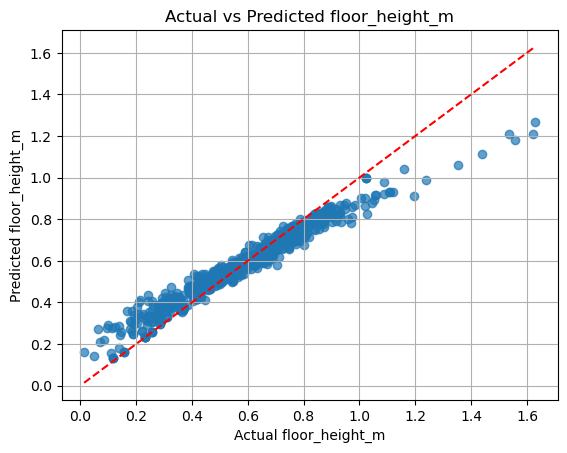

In [78]:
# Fit the best model on all data points
best_model.fit(X_lt_2m, y_lt_2m, regressor__sample_weight=weights)


# Get predictions for all data points
predictions = best_model.predict(X_lt_2m)

# Calculate explained variance
explained_variance = r2_score(y_lt_2m, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_lt_2m, predictions))
print(f"RMSE: {rmse}")

plt.scatter(y_lt_2m, predictions, alpha=0.7)
plt.plot([y_lt_2m.min(), y_lt_2m.max()], [y_lt_2m.min(), y_lt_2m.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)

### Train and validate using best model


Explained Variance (R^2): 0.3760
RMSE: 0.1851635852681762
RMSE (corrected): 0.18343896031227533
Explained Variance (R^2) (random): -1.0342
RMSE (random): 0.33432202037318076


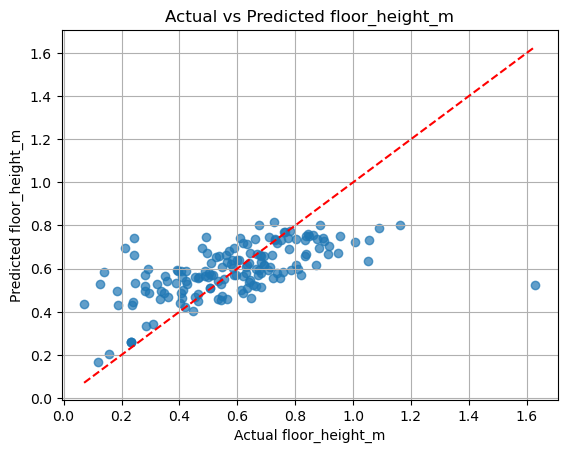

In [79]:
# Bin the target variable into 10 bins
y_binned = pd.cut(y_lt_2m, bins=10, labels=False)

# Split the dataset into training and validation sets stratified by target values
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X_lt_2m, y_lt_2m, weights, test_size=0.25, stratify=y_binned, random_state=42
)

# Create a Random Forest Regressor model
#best_model = Pipeline([
#    ('correlation_filter', CorrelationFilter(threshold=0.8)),
#    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=30)) #, max_features='sqrt', min_samples_split=2)
#])

#X_train = np.vstack((X_train, X_transformed_wagga))
#y_train = np.concatenate((y_train, y_wagga))

# Fit the best model on all data points
best_model.fit(X_train, y_train, regressor__sample_weight=weights_train)

# Additional correction
predictions = best_model.predict(X_train)
# Generate polynomial features (degree can be adjusted)
poly = PolynomialFeatures(degree=2)  # You can try different degrees, e.g., 2, 3, etc.
poly.fit(predictions.reshape(-1, 1))
y_pred_poly = poly.transform(predictions.reshape(-1, 1))

# Fit a linear regression model to the polynomial features
poly_model = LinearRegression()
poly_model.fit(y_pred_poly, y_train)

# Get predictions for all data points
predictions = best_model.predict(X_val)
# Additional correction
y_pred_poly = poly.transform(predictions.reshape(-1, 1))
predictions_corrected = poly_model.predict(y_pred_poly)

# Calculate explained variance
explained_variance = r2_score(y_val, predictions)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"RMSE: {rmse}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, predictions_corrected))
print(f"RMSE (corrected): {rmse}")

plt.scatter(y_val, predictions, alpha=0.7)
#plt.scatter(y_val, predictions_corrected, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target}')
plt.ylabel(f'Predicted {target}')
plt.grid(True)

# Compare to random
pred_random = np.random.choice(y_val, size=len(y_val), replace=True)
explained_variance = r2_score(y_val, pred_random)
print(f"Explained Variance (R^2) (random): {explained_variance:.4f}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, pred_random))
print(f"RMSE (random): {rmse}")

## Apply to Wagga Wagga

Explained Variance (R^2): -0.0120
RMSE: 0.3117209650662017
Explained Variance (R^2) (random): -0.9302
RMSE (random): 0.430498665876662


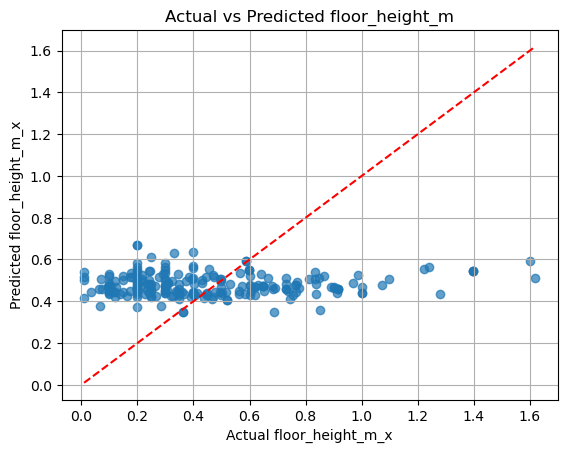

In [80]:
target_wagga = 'floor_height_m_x'
X_wagga = gdf_footprint_Wagga[cat_features + num_features]
y_wagga = gdf_footprint_Wagga[target_wagga]

# Apply the tranformation
X_encoded_wagga = encoder.transform(X_wagga[cat_features])
X_normalized_wagga = scaler.transform(X_wagga[num_features])

# Concatenate the encoded categorical features with the normalized numeric features
X_transformed_wagga = np.hstack((X_encoded_wagga, X_normalized_wagga))


# Get predictions for all data points
predictions_wagga = best_model.predict(X_transformed_wagga)

# Correct additional bias
#y_pred_poly = poly.transform(predictions_wagga.reshape(-1, 1))
#predictions_wagga = poly_model.predict(y_pred_poly)

# Calculate explained variance
explained_variance = r2_score(y_wagga, predictions_wagga)
print(f"Explained Variance (R^2): {explained_variance:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_wagga, predictions_wagga))
print(f"RMSE: {rmse}")

plt.scatter(y_wagga, predictions_wagga, alpha=0.7)
plt.plot([y_wagga.min(), y_wagga.max()], [y_wagga.min(), y_wagga.max()], 'r--')  # Diagonal line
plt.title(f'Actual vs Predicted {target}')
plt.xlabel(f'Actual {target_wagga}')
plt.ylabel(f'Predicted {target_wagga}')
plt.grid(True)

# Compare to random
pred_random_wagga = np.random.choice(y_wagga, size=len(y_wagga), replace=True)
explained_variance = r2_score(y_wagga, pred_random_wagga)
print(f"Explained Variance (R^2) (random): {explained_variance:.4f}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_wagga, pred_random_wagga))
print(f"RMSE (random): {rmse}")

